# Importing packages

In [1]:
# importing libraries


import importlib
import subprocess
import sys

def install_and_import(package, import_name=None):
    """
    Try to import a package. If it's not installed, install it via pip and import again.
    """
    if import_name is None:
        import_name = package

    try:
        return importlib.import_module(import_name)
    except ImportError:
        print(f"{import_name} not found, installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return importlib.import_module(import_name)


# --- Install + import core packages ---
np = install_and_import("numpy")
pd = install_and_import("pandas")
plt = install_and_import("matplotlib", "matplotlib.pyplot")
pytictoc = install_and_import("pytictoc")
# --- Install + import scikit-learn ---
sklearn = install_and_import("scikit-learn", "sklearn")

# Dataset & model selection
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, cross_validate
)

# Preprocessing
from pytictoc import TicTocfrom sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- MODELS ---
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

# --- METRICS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
seed = 314+133+76223+3+5
np.random.seed(seed)
t = TicToc() #create instance of class for timer
t.tic() #Start timer

print("All regression-related libraries imported successfully!")

All regression-related libraries imported successfully!


# Loading the dataset

In [2]:
#Load the dataset
data = pd.read_csv("../data/filtered_data_anal.csv")
print(data.head())

   site_id_(telephely)  class_size  math_score_8_std mother_education_level  \
0              2720701          20          0.059560  apprenticeship_school   
1              2720701          13         -0.001199  apprenticeship_school   
2              2720701          13         -1.992139         primary_school   
3              2720701          20          0.002098      vocational_school   
4              2720701          20          0.165419                college   

  father_education_level   books_at_home  family_background_index_std  \
0             university         300_600                     0.731792   
1  apprenticeship_school            0_50                    -1.247200   
2      less_than_primary            0_50                    -1.915730   
3  apprenticeship_school       up_to_150                    -0.551291   
4  apprenticeship_school  more_than_1000                     0.949264   

  student_gender class_curriculum_type multiplied_disadvantaged  \
0            boy   

# Step 1: Train-test split

In [3]:
#Step 1: Naming the targetv variable and splitting the data
target_column = "math_score_8_std"

#Train-test split
from sklearn.model_selection import RepeatedKFold
X = data.drop(columns = target_column).copy()
y = data[target_column].copy()

# 20% hold out of the data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 45255, Test samples: 11314


# Step 2: Preprocessing for tree-based models

In [4]:
#Step 2: Identifying numeric and categorical features

numeric_features = selector(dtype_include=np.number)(X)
categorical_features = selector(dtype_include=object)(X)

# OneHotEncoder dense
ohe_dense = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Numeric pipeline: impute median
numeric_pipe_tree = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Categorical pipeline: impute most frequent + one-hot encode
categorical_pipe_tree = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe_dense)
])

# Full preprocessor for tree models
preprocess_for_tree = ColumnTransformer([
    ('num', numeric_pipe_tree, numeric_features),
    ('cat', categorical_pipe_tree, categorical_features)
], remainder='drop', sparse_threshold=0.0)  # dense output


# Step 3: Define repeated 5-fold cross-validation

In [5]:
#Step 3: Define repeated 5-fold cross-validation
from sklearn.model_selection import RepeatedKFold

# 5-fold CV repeated 5 times for stable estimates
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)


# Step 4: Hyperparameter grids

In [6]:
#Step 4: Hyperparameter grids
#Decision tree
param_grid_tree = {
    'model__max_depth': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 5, 20]
}

#Random forest
param_grid_rf = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 5],
    'model__max_features': ['sqrt', 'log2', 0.3]
}


# Step 5: Build pipelines

In [7]:
#Step 5: Build pipelines
tree_pipe = Pipeline([
    ('preprocess', preprocess_for_tree),
    ('model', DecisionTreeRegressor(random_state=seed))
])
rf_pipe = Pipeline([
    ('preprocess', preprocess_for_tree),
    ('model', RandomForestRegressor(random_state=seed, n_jobs=-1))
])


# Step 6: Grid search CV to find optimal hyperparameters

In [8]:
#Step 6: Grid search CV to find optimal hyperparameters
#TREE
tree_gs = GridSearchCV(
    tree_pipe,
    param_grid_tree,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
tree_gs.fit(X_train, y_train)

print("Best Decision Tree params:", tree_gs.best_params_)
print("CV RMSE (mean of best):", -tree_gs.best_score_)

#RF
rf_gs = GridSearchCV(
    rf_pipe,
    param_grid_rf,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rf_gs.fit(X_train, y_train)

print("Best Random Forest params:", rf_gs.best_params_)
print("CV RMSE (mean of best):", -rf_gs.best_score_)


Best Decision Tree params: {'model__max_depth': 5, 'model__min_samples_leaf': 20}
CV RMSE (mean of best): 0.8448248722047693
Best Random Forest params: {'model__max_depth': 20, 'model__max_features': 0.3, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
CV RMSE (mean of best): 0.8283807032280899


# Step 7: Evaluate on held-out test set

In [9]:
#Step 7: Evaluate on held-out test set
# Decision Tree test evaluation
y_pred_tree = tree_gs.best_estimator_.predict(X_test)
print("\nDecision Tree Test Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tree)))
print("R²:", r2_score(y_test, y_pred_tree))
print("MAE:", mean_absolute_error(y_test, y_pred_tree))

# Random Forest test evaluation
y_pred_rf = rf_gs.best_estimator_.predict(X_test)
print("\nRandom Forest Test Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))



Decision Tree Test Performance:
RMSE: 0.8317687901748355
R²: 0.2536888426614595
MAE: 0.6637259788309632

Random Forest Test Performance:
RMSE: 0.8149549868774997
R²: 0.28355651730333387
MAE: 0.649665888024766


# Plotting the best decision tree

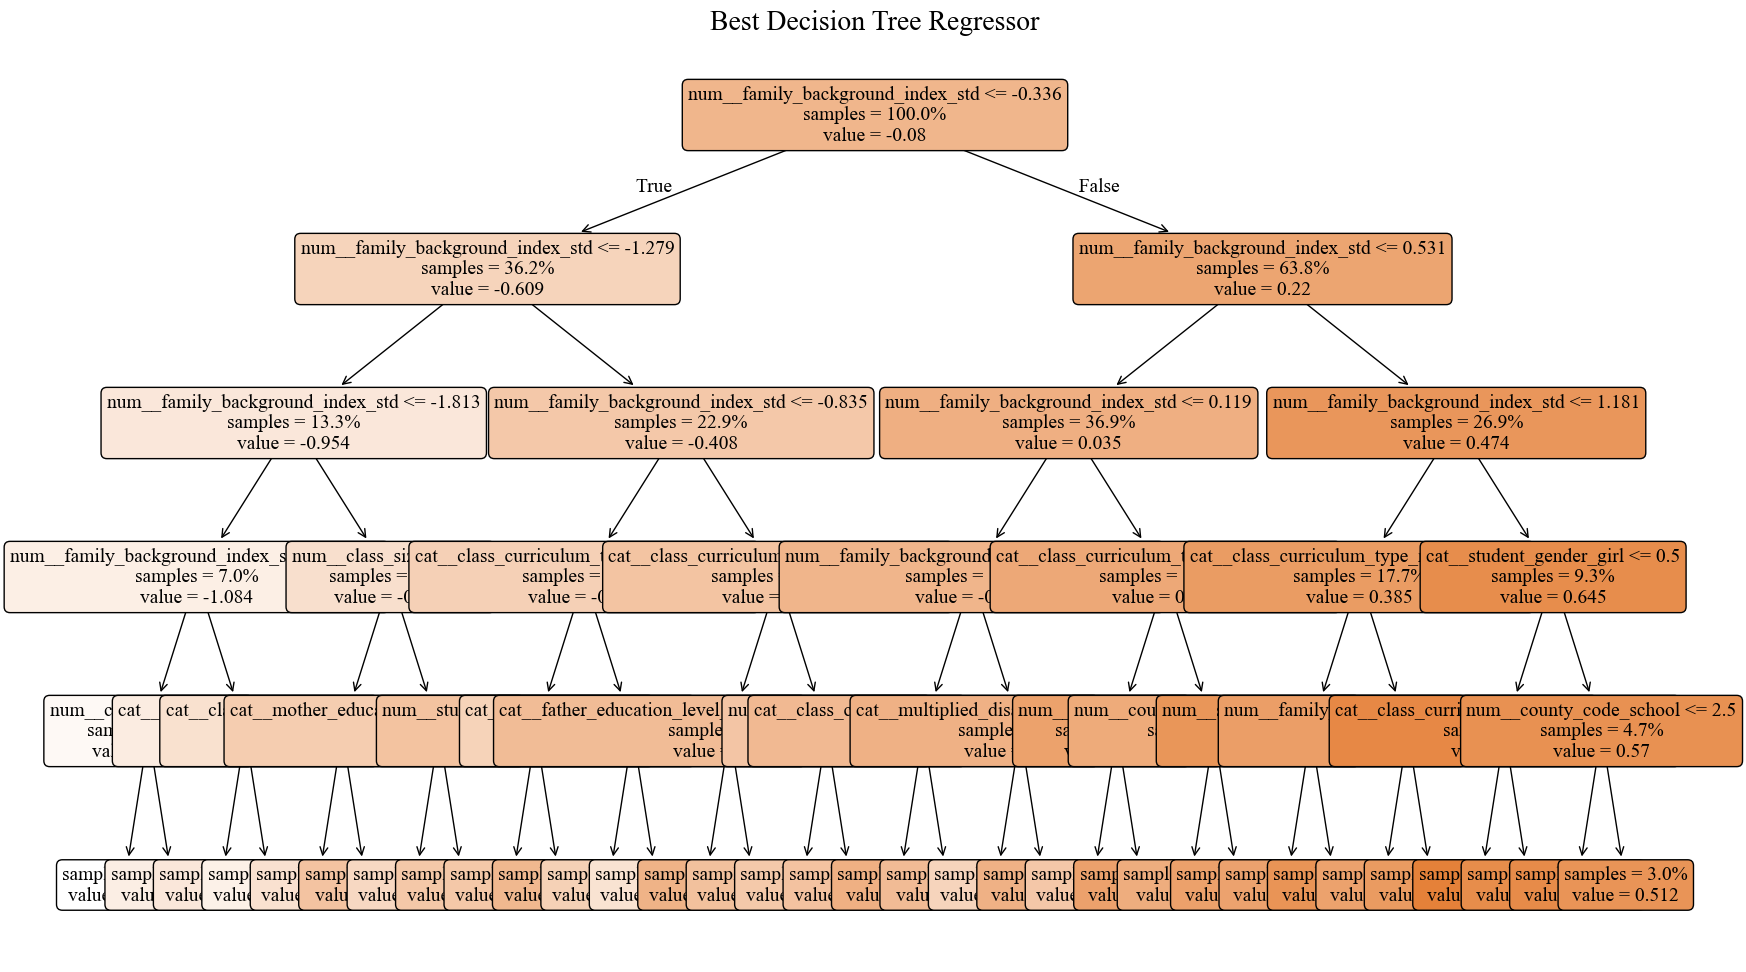

In [19]:
# Extract the best Decision Tree model from the GridSearchCV
best_tree_model = tree_gs.best_estimator_.named_steps['model']

plt.rcParams["font.family"] = "Times New Roman"

# Get feature names after preprocessing
feature_names = tree_gs.best_estimator_.named_steps['preprocess'].get_feature_names_out()

# Plot the tree
plt.figure(figsize=(20, 12))
plot_tree(
    best_tree_model,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=14,
    proportion=True,   
    impurity=False    
)
plt.title("Best Decision Tree Regressor", fontsize=20)
plt.savefig('../figures/decision_tree_tree.png', dpi=300, bbox_inches='tight')
plt.show()


# Calculating the importance of the variables in the best random forest

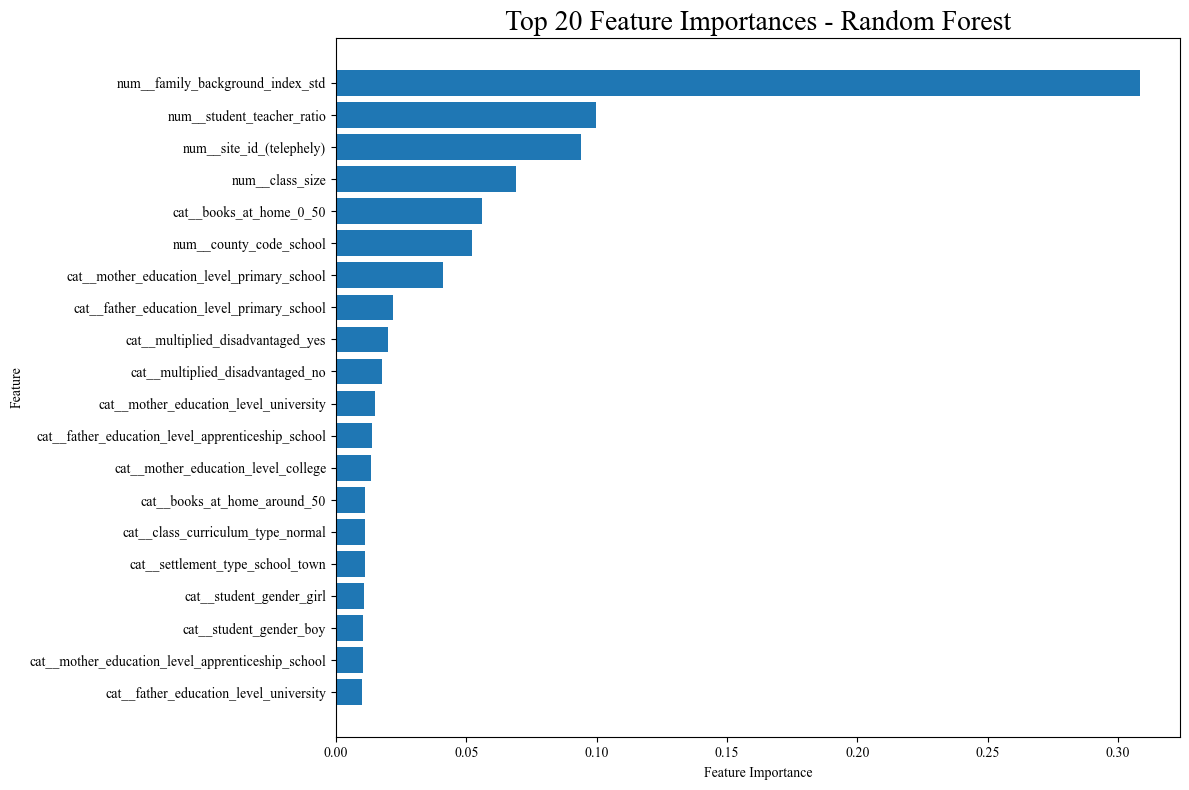

                                              feature  importance
2                    num__family_background_index_std    0.308296
4                          num__student_teacher_ratio    0.099690
0                            num__site_id_(telephely)    0.094083
1                                     num__class_size    0.068856
19                            cat__books_at_home_0_50    0.056096
3                             num__county_code_school    0.052060
8          cat__mother_education_level_primary_school    0.041043
15         cat__father_education_level_primary_school    0.021921
33                  cat__multiplied_disadvantaged_yes    0.020101
32                   cat__multiplied_disadvantaged_no    0.017580
10             cat__mother_education_level_university    0.015022
12  cat__father_education_level_apprenticeship_school    0.013971
6                 cat__mother_education_level_college    0.013483
22                       cat__books_at_home_around_50    0.011162
30        

<Figure size 640x480 with 0 Axes>

In [18]:
#9. Extract best Random Forest from GridSearchCV
best_rf_model = rf_gs.best_estimator_.named_steps['model']

# Get feature names after preprocessing
feature_names = rf_gs.best_estimator_.named_steps['preprocess'].get_feature_names_out()

# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for easier sorting and plotting
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
plt.barh(importances_df['feature'][:20][::-1], importances_df['importance'][:20][::-1])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - Random Forest', fontsize=20)
plt.tight_layout()
plt.savefig('../figures/random_forest_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print(importances_df)

In [12]:
#Time elapsed since t.tic()
t.toc()

Elapsed time is 1216.267854 seconds.
